This demo shows how to use integrated gradients in graph convolutional networks to obtain accurate importance estimations for both the nodes and edges. 

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import os
import time
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
import keras
from keras import layers, optimizers, losses, metrics, Model, regularizers
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph.core.utils import GCN_Aadj_feats_op
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/wu061/anaconda3/envs/stellar-research-py35/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


### Loading the CORA network

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [2]:
data_dir = os.path.expanduser("~/data/cora")

Load the graph from edgelist

In [3]:
edgelist = pd.read_table(os.path.join(data_dir, "cora.cites"), header=None, names=["source", "target"])
edgelist["label"] = "cites"

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [5]:
train_data, test_data = model_selection.train_test_split(node_data, train_size=140, test_size=None, stratify=node_data['subject'])
val_data, test_data = model_selection.train_test_split(test_data, train_size=500, test_size=None, stratify=test_data['subject'])

In [6]:
from collections import Counter
Counter(train_data['subject'])

Counter({'Probabilistic_Methods': 22,
         'Case_Based': 16,
         'Theory': 18,
         'Reinforcement_Learning': 11,
         'Neural_Networks': 42,
         'Rule_Learning': 9,
         'Genetic_Algorithms': 22})

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [7]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
val_targets = target_encoding.transform(val_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))

node_ids = node_data.index
all_targets = target_encoding.transform(
        node_data[["subject"]].to_dict("records")
    )
node_features = node_data[feature_names]
G = sg.StellarGraph(Gnx, node_features=node_features)
print(G.info())


StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



### Creating the GCN model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

To feed data from the graph to the Keras model we need a generator. Since GAT is a full-batch model, we use the `FullBatchNodeGenerator` class to feed node features and graph adjacency matrix to the model.

In [8]:
generator = FullBatchNodeGenerator(G, func_opt=GCN_Aadj_feats_op, filter='localpool')

Using local pooling filters...


For training we map only the training nodes returned from our splitter and the target values.

In [9]:
train_gen = generator.flow(train_data.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

the layer_sizes is a list of hidden feature sizes of each layer in the model. In this example we use two GCN layers with 16/7-dimensional hidden node features at each layer.
activations is a list of activations applied to each layer's output
Arguments such as bias, dropout, kernel_regularizer are internal parameters of the model, execute GCN for details.

In [10]:
layer_sizes = [16, 16]
gcn = GCN(layer_sizes=layer_sizes, activations=["elu", "elu"], generator=generator, bias=True, dropout=0.3,kernel_regularizer=regularizers.l2(5e-4))

In [37]:
# Expose the input and output tensors of the GCN model for node prediction, via GCN.node_model() method:
x_inp, x_out = gcn.node_model()
# Snap the final estimator layer to x_out
x_out = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `x_out` from the final dense layer

In [12]:
model = keras.Model(inputs=x_inp, outputs=x_out)

In [13]:
model.compile(
    optimizer=optimizers.Adam(lr=0.005),# decay=0.001),
    loss=losses.categorical_crossentropy,
    weighted_metrics=[metrics.categorical_accuracy],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [14]:
val_gen = generator.flow(val_data.index, val_targets)

In [15]:
N = len(node_ids)
[X, A], y_train, node_mask_train = train_gen.__getitem__(0)
[_, _], y_val, node_mask_val = val_gen.__getitem__(0)

Train the model

In [36]:
history = model.fit(x=[X, A], y=y_train, sample_weight=node_mask_train,
                    batch_size=N, shuffle=False, epochs=50, verbose=2,
                    validation_data=([X, A], y_val, node_mask_val))

Train on 2708 samples, validate on 2708 samples
Epoch 1/50
 - 0s - loss: 0.1684 - weighted_categorical_accuracy: 1.0000 - val_loss: 0.7802 - val_weighted_categorical_accuracy: 0.7960
Epoch 2/50
 - 0s - loss: 0.1601 - weighted_categorical_accuracy: 1.0000 - val_loss: 0.7794 - val_weighted_categorical_accuracy: 0.7940
Epoch 3/50
 - 0s - loss: 0.1575 - weighted_categorical_accuracy: 1.0000 - val_loss: 0.7796 - val_weighted_categorical_accuracy: 0.7920
Epoch 4/50
 - 0s - loss: 0.1578 - weighted_categorical_accuracy: 1.0000 - val_loss: 0.7810 - val_weighted_categorical_accuracy: 0.7940
Epoch 5/50
 - 0s - loss: 0.1532 - weighted_categorical_accuracy: 1.0000 - val_loss: 0.7829 - val_weighted_categorical_accuracy: 0.7920
Epoch 6/50
 - 0s - loss: 0.1603 - weighted_categorical_accuracy: 0.9929 - val_loss: 0.7849 - val_weighted_categorical_accuracy: 0.7920
Epoch 7/50
 - 0s - loss: 0.1469 - weighted_categorical_accuracy: 1.0000 - val_loss: 0.7871 - val_weighted_categorical_accuracy: 0.7920
Epoch 8

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='best')
        plt.show()

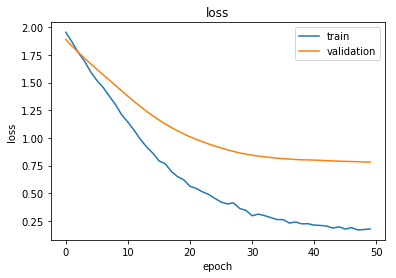

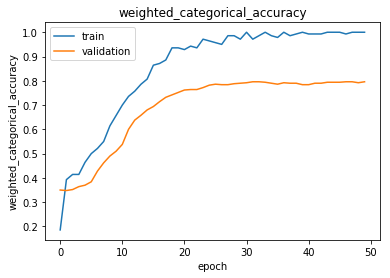

In [18]:
plot_history(history)

Evaluate the trained model on the test set

In [19]:
[_, _], y_test, node_mask_test = generator.flow(test_data.index, test_targets).__getitem__(0)
test_metrics = model.evaluate(x=[X, A], y=y_test, sample_weight=node_mask_test, batch_size=N)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2708/2708 [==============================] - 0s 13us/step

Test Set Metrics:
	loss: 0.8283
	weighted_categorical_accuracy: 0.7921


# Node and link importance via saliency maps

Now we define the importances of node features, nodes, and links in the target node's neighbourhood (ego-net), and evaluate them using our library. 

Node *feature importance*: given a target node $t$ and the model's prediction of $t$'s class, for each node $v$ in its ego-net, feature importance of feature $f$ for node $v$ is defined as the change in the target node's predicted score $s(c)$ for the winning class $c$ if feature $f$ of node $v$ is perturbed. 

The overall *node importance* for node $v$ is defined here as the sum of all feature importances for node $v$, i.e., it is the amount by which the target node's predicted score $s(c)$ would change if we set all features of node $v$ to zeros.

*Link importance* for link $e=(u, v)$ is defined as the change in target node $t$'s predicted score $s(c)$ if the link $e$ is removed from the graph. Links with high importance (positive or negative) affect the target node prediction more than links with low importance. 

Node and link importances can be used to assess the role of neighbour nodes and links in model's predictions for the node(s) of interest (the target nodes). For datasets like CORA-ML, the features and edges are binary, vanilla gradients may not perform well so we use integrated gradients to compute them (https://arxiv.org/pdf/1703.01365.pdf).

Another interesting application of node and link importances is to identify model vulnerabilities to attacks via perturbing node features and graph structure (see https://arxiv.org/abs/1903.01610).

In [20]:
from stellargraph.utils.saliency_maps.integrated_gradients import IntegratedGradients
from stellargraph.utils.saliency_maps.saliency import GradientSaliency

Select the target node whose prediction is to be interpreted

In [21]:
target_idx = 7   # index of the target node in G.nodes()

Node id of the target node:

In [22]:
target_nid = list(G.nodes())[target_idx]
y_true = all_targets[list(node_ids).index(target_nid)]  # true class of the target node
print(target_nid)

1109199


In [23]:
N = len(node_ids)
[X, A], _, _ = train_gen.__getitem__(0)
y_pred = model.predict([X, A], batch_size=N)[target_idx]  # predicted class of the target node
class_of_interest = np.argmax(y_pred)

print("target node id: {}, \ntrue label: {}, \npredicted label: {}".format(target_nid, y_true, y_pred.round(2)))

target node id: 1109199, 
true label: [0. 1. 0. 0. 0. 0. 0.], 
predicted label: [0.16 0.5  0.07 0.02 0.14 0.11 0.  ]


Get the node feature importance by using integrated gradients

In [35]:
int_grad_saliency = IntegratedGradients(model)

adjacency matrix tensor is sparse


For the parameters of get_node_importance method, X and A are the feature and adjacency matrices, respectively. target_idx is the node of interest and class_of_interest is normally set as the predicted label of the node. steps indicates the number of integrations. A larger steps give better approximations with higher computational overhead.

In [25]:
integrated_node_importance = int_grad_saliency.get_node_importance(X, A, target_idx, class_of_interest, steps=50)

In [26]:
print('\nintegrated_node_importance', integrated_node_importance.round(2))
print('integrated self-importance of target node {}: {}'.format(target_nid, integrated_node_importance[target_idx].round(2)))


integrated_node_importance [3.35 0.13 0.02 ... 0.   0.   0.  ]
integrated self-importance of target node 1109199: -1.45


Check that number of non-zero node importance values is less or equal the number of nodes in target node's K-hop ego net (where K is the number of GCN layers in the model)

In [27]:
G_ego = nx.ego_graph(G, target_nid, radius=len(gcn.activations))

In [28]:
print('Number of nodes in the ego graph: {}'.format(len(G_ego.nodes())))
print("Number of non-zero elements in integrated_node_importance: {}".format(np.count_nonzero(integrated_node_importance)))

Number of nodes in the ego graph: 202
Number of non-zero elements in integrated_node_importance: 202


Compute the link importance by integrated gradients. Note that the importance for existing and potential edges are computed differently.

In [29]:
integrate_link_importance = int_grad_saliency.get_integrated_link_masks(X, A, target_idx, class_of_interest, A_baseline = None, steps=50)
print('integrate_link_importance.shape = {}'.format(integrate_link_importance.shape))

integrate_link_importance.shape = (2708, 2708)


Some sanity checks:
We expect the number of non-zero elements in the integrated link importance be same or less than the number of real edges in the ego graph.

In [30]:
#The built-in number_of_edges function for the ego graph does not count the self-loops and some reversed edges
#in the non-directed graph so we do the sanity check as the following.
G_ego_edges = set()
for i in np.nonzero(A[target_idx])[1]:
    G_ego_edges.add((list(G.nodes())[target_idx], list(G.nodes())[i]))
    for j in np.nonzero(A[i])[1]:
        G_ego_edges.add((list(G.nodes())[i], list(G.nodes())[j]))
print("Number of edges in the ego graph: {}".format(len(G_ego_edges)))
print("Number of non-zero elements in integrate_link_importance: {}".format(np.count_nonzero(integrate_link_importance)))

Number of edges in the ego graph: 210
Number of non-zero elements in integrate_link_importance: 210


In [31]:
sorted_indices = np.argsort(integrate_link_importance.flatten().reshape(-1))
sorted_indices = np.array(sorted_indices)[0]
nodes = list(G.nodes())
integrated_link_importance_rank = [(nodes[int(k/N)], nodes[k%N]) for k in sorted_indices[::-1]]
topk = 10
print('Top {} most important links by integrated gradients are {}'.format(topk, integrated_link_importance_rank[-topk:]))

Top 10 most important links by integrated gradients are [(6214, 1106172), (6214, 345340), (6214, 6215), (6214, 38480), (6214, 1105764), (6214, 6378), (6214, 124064), (6214, 95589), (148170, 1109199), (1109199, 6214)]


In [32]:
#Set the labels as an attribute for the nodes in the graph. The labels are used to color the nodes in different classes.
nx.set_node_attributes(G_ego, values={x[0]:{'subject': x[1]} for x in node_data['subject'].items()})

In the following, we plot the link and node importance (computed by integrated gradients) of the nodes within the ego graph of the target node. 

For nodes, the shape of the node indicates the positive/negative importance the node has. 'round' nodes have positive importance while 'diamond' nodes have negative importance. The size of the node indicates the value of the importance, e.g., a large diamond node has higher negative importance. 

For links, the color of the link indicates the positive/negative importance the link has. 'red' links have positive importance while 'blue' links have negative importance. The width of the link indicates the value of the importance, e.g., a thicker blue link has higher negative importance.

/home/wu061/anaconda3/envs/stellar-research-py35/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


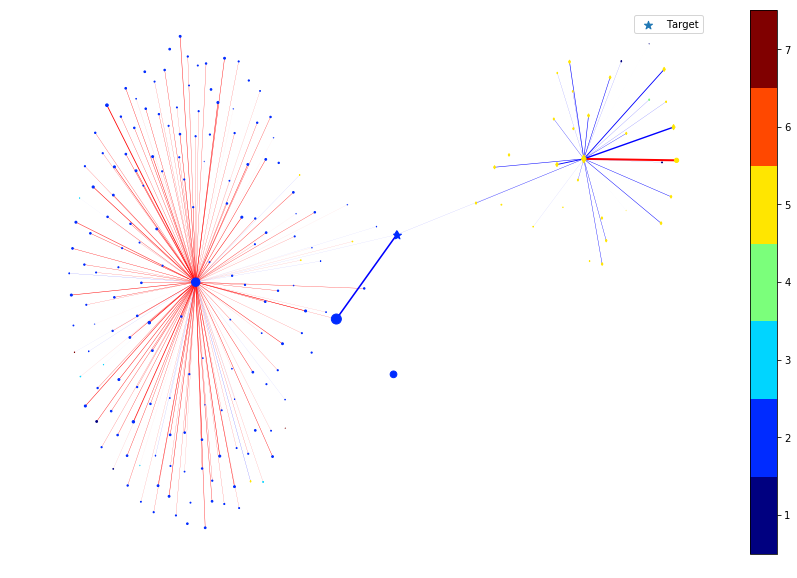

In [33]:
node_size_factor = 1e2
link_width_factor = 2

nodes = list(G_ego.nodes())
colors = pd.DataFrame([v[1]['subject'] for v in G_ego.nodes(data=True)], index=nodes, columns=['subject'])
colors = np.argmax(target_encoding.transform(colors.to_dict('records')), axis=1) + 1

fig, ax = plt.subplots(1, 1, figsize=(15, 10));
pos = nx.spring_layout(G_ego)
# Draw ego as large and red
node_sizes = [integrated_node_importance[list(G.nodes()).index(k)] for k in G_ego.nodes()]
node_shapes = ['o' if integrated_node_importance[list(G.nodes()).index(k)] > 0 else 'd' for k in G_ego.nodes()]
positive_colors, negative_colors = [], []
positive_node_sizes, negative_node_sizes = [], []
positive_nodes, negative_nodes = [], []
#node_size_sclae is used for better visualization of nodes
node_size_scale = node_size_factor/np.max(node_sizes)
for k in range(len(node_shapes)):
    if list(nodes)[k] == target_idx:
        continue
    if node_shapes[k] == 'o':
        positive_colors.append(colors[k])
        positive_nodes.append(list(nodes)[k])
        positive_node_sizes.append(node_size_scale*node_sizes[k])

    else:
        negative_colors.append(colors[k])
        negative_nodes.append(list(nodes)[k])
        negative_node_sizes.append(node_size_scale*abs(node_sizes[k]))



cmap = plt.get_cmap('jet', np.max(colors)-np.min(colors)+1)
nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=positive_nodes, node_color=positive_colors, cmap=cmap, node_size=positive_node_sizes, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, node_shape='o')
nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=negative_nodes, node_color=negative_colors, cmap=cmap, node_size=negative_node_sizes, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, node_shape='d')
# Draw the target node as a large star colored by its true subject
nx.draw_networkx_nodes(G_ego, pos, nodelist=[target_nid], node_size=50*abs(node_sizes[nodes.index(target_nid)]), node_shape='*',
                       node_color=[colors[nodes.index(target_nid)]], cmap=cmap, vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, label="Target")

edges = G_ego.edges()
#link_width_scale is used for better visualization of links
weights = [integrate_link_importance[list(G.nodes()).index(u),list(G.node()).index(v)] for u,v in edges]
link_width_scale = link_width_factor/np.max(weights)
edge_colors = ['red' if integrate_link_importance[list(G.nodes()).index(u),list(G.node()).index(v)] > 0 else 'blue' for u,v in edges]

ec = nx.draw_networkx_edges(G_ego, pos, edge_color=edge_colors,  width = [link_width_scale*w for w in weights])
plt.legend()
plt.colorbar(nc, ticks=np.arange(np.min(colors),np.max(colors)+1))
plt.axis('off')
plt.show()

We then remove the node or edge in the ego graph one by one and check how the prediction changes. By doing so, we can obtain the ground truth importance of the nodes and edges. Comparing the following figure and the above one can show the effectiveness of integrated gradients as the importance approximations are relatively consistent with the ground truth.

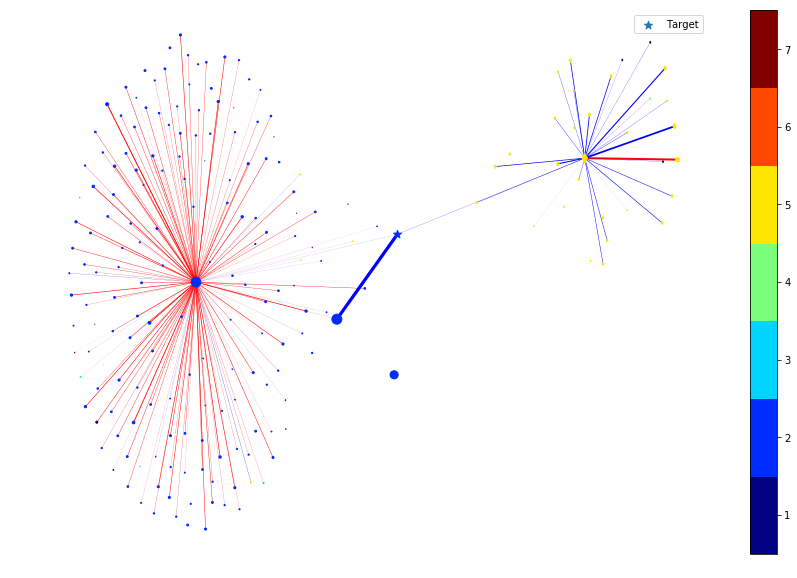

In [34]:
X_bk = deepcopy(X)
edges = [(list(G.nodes()).index(u),list(G.node()).index(v)) for u,v in G_ego.edges()]
nodes = [list(G.node()).index(v) for v in G_ego.nodes()]
clean_prediction = model.predict([X, A], batch_size=N)[target_idx]
predict_label = np.argmax(clean_prediction)
groud_truth_edge_importance = np.zeros(A.shape, dtype = 'float')
groud_truth_node_importance = []

for node in nodes:
    if node == target_idx:
        groud_truth_node_importance.append(0)
        continue
    X = deepcopy(X_bk)
    #we set all the features of the node to zero to check the ground truth node importance.
    X[node, :] = 0
    predict_after_perturb = model.predict([X, A], batch_size=N)[target_idx]  
    prediction_change = clean_prediction[predict_label] - predict_after_perturb[predict_label]
    groud_truth_node_importance.append(prediction_change)

node_shapes = ['o' if groud_truth_node_importance[k] > 0 else 'd' for k in range(len(nodes))]
positive_colors, negative_colors = [], []
positive_node_sizes, negative_node_sizes = [], []
positive_nodes, negative_nodes = [], []
#node_size_scale is used for better visulization of nodes
node_size_scale = node_size_factor/max(groud_truth_node_importance)

for k in range(len(node_shapes)):
    if nodes[k] == target_idx:
        continue
    if node_shapes[k] == 'o':
        positive_colors.append(colors[k])
        positive_nodes.append(list(G.nodes())[nodes[k]])
        positive_node_sizes.append(node_size_scale*groud_truth_node_importance[k])
    else:
        negative_colors.append(colors[k])
        negative_nodes.append(list(G.nodes())[nodes[k]])
        negative_node_sizes.append(node_size_scale*abs(groud_truth_node_importance[k]))
        
X = deepcopy(X_bk)
for edge in edges:
    original_val = A[edge[0], edge[1]]
    if original_val == 0:
        continue
    #we set the weight of a given edge to zero to check the ground truth link importance
    A[edge[0], edge[1]] = 0
    predict_after_perturb = model.predict([X, A], batch_size=N)[target_idx]  
    groud_truth_edge_importance[edge[0], edge[1]] = (predict_after_perturb[predict_label] - clean_prediction[predict_label])/(0 - 1)
    A[edge[0], edge[1]] = original_val
#     print(groud_truth_edge_importance[edge[0], edge[1]])

fig, ax = plt.subplots(1, 1, figsize=(15, 10));
cmap = plt.get_cmap('jet', np.max(colors)-np.min(colors)+1)
# Draw the target node as a large star colored by its true subject
nx.draw_networkx_nodes(G_ego, pos, nodelist=[target_nid], node_size=50*abs(node_sizes[nodes.index(target_idx)]), node_color=[colors[nodes.index(target_idx)]], cmap=cmap, 
                       node_shape='*', vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, label="Target")
# Draw the ego net
nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=positive_nodes, node_color=positive_colors, cmap=cmap, node_size=positive_node_sizes, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, node_shape='o')
nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=negative_nodes, node_color=negative_colors, cmap=cmap, node_size=negative_node_sizes, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, node_shape='d')
edges = G_ego.edges()
#link_width_scale is used for better visulization of links
link_width_scale = link_width_factor/np.max(groud_truth_edge_importance)
weights = [link_width_scale*groud_truth_edge_importance[list(G.nodes()).index(u),list(G.node()).index(v)] for u,v in edges]

edge_colors = ['red' if groud_truth_edge_importance[list(G.nodes()).index(u),list(G.node()).index(v)] > 0 else 'blue' for u,v in edges]

ec = nx.draw_networkx_edges(G_ego, pos, edge_color=edge_colors, width = weights)
plt.legend()
plt.colorbar(nc, ticks=np.arange(np.min(colors),np.max(colors)+1))
plt.axis('off')
plt.show()

By comparing the above two figures, one can see that the integrated gradients are quite consistent with the brute-force approach. The main benefit of using integrated gradients is scalability. The gradient operations are very efficient to compute on deep learning frameworks with the parallism provided by GPUs. Also, integrated gradients can give the importance of individual node features, for all nodes in the graph. Achieving this by brute-force approch is often non-trivial. 